In [1]:
import numpy as np

import matplotlib.pyplot as plt

import random
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')
from scipy.ndimage import label
import powerlaw

In [2]:
import numpy as np
from scipy.special import zeta # For normalization
from scipy.ndimage import label
from scipy.ndimage import find_objects

def fit_power_law_numpy(data):
    """
    Fits a power-law distribution to discrete data using the Clauset, Shalizi, Newman method.

    Returns a dictionary containing fit parameters and data for plotting.
    """
    # --- The first part of the function (finding the best alpha and xmin) is the same ---
    possible_xmins = np.unique(data)
    possible_xmins = possible_xmins[possible_xmins < np.max(possible_xmins)]

    if len(possible_xmins) < 2:
        return {'alpha': 1.0, 'xmin': 1, 'ks_distance': 1.0, 'fit_successful': False}

    ks_distances = []
    alphas = []

    for xmin_candidate in possible_xmins:
        tail_data = data[data >= xmin_candidate]
        n_tail = len(tail_data)
        if n_tail < 10:
            ks_distances.append(np.inf)
            alphas.append(1.0)
            continue

        alpha_mle = 1.0 + n_tail / np.sum(np.log(tail_data / (xmin_candidate - 0.5)))
        alphas.append(alpha_mle)

        empirical_cdf = np.arange(1, n_tail + 1) / n_tail
        unique_tail_data, counts = np.unique(tail_data, return_counts=True)

        # This part has been simplified for clarity, the logic is the same
        theoretical_cdf = np.cumsum((unique_tail_data**-alpha_mle) / zeta(alpha_mle, xmin_candidate))
        cdf_map = dict(zip(unique_tail_data, theoretical_cdf))
        theoretical_cdf_full = np.array([cdf_map[val] for val in tail_data])

        ks_distance = np.max(np.abs(empirical_cdf - theoretical_cdf_full))
        ks_distances.append(ks_distance)

    if np.all(np.isinf(ks_distances)):
        return {'alpha': 1.0, 'xmin': 1, 'ks_distance': 1.0, 'fit_successful': False}

    best_idx = np.argmin(ks_distances)
    best_xmin = possible_xmins[best_idx]
    best_alpha = alphas[best_idx]
    min_ks_distance = ks_distances[best_idx]

    # --- NEW: Calculate data for plotting ---

    # 1. Empirical PDF (Probability Density Function)
    unique_sizes, counts = np.unique(data, return_counts=True)
    empirical_pdf_y = counts / len(data)
    empirical_pdf_x = unique_sizes

    # 2. Theoretical PDF (the fitted line)
    # The line should only be drawn for x >= xmin
    fit_pdf_x = np.arange(best_xmin, np.max(data) + 1, dtype=np.float64)
    # Normalization constant C = 1 / zeta(alpha, xmin)
    normalization_const = 1 / zeta(best_alpha, best_xmin)
    fit_pdf_y = normalization_const * (fit_pdf_x ** -best_alpha)

    # 3. Package everything into a dictionary
    results = {
        'alpha': best_alpha,
        'xmin': best_xmin,
        'ks_distance': min_ks_distance,
        'fit_successful': True,
        'empirical_pdf_x': empirical_pdf_x,
        'empirical_pdf_y': empirical_pdf_y,
        'fit_pdf_x': fit_pdf_x,
        'fit_pdf_y': fit_pdf_y
    }

    return results
#-------------------------------------------------------------#
#-------------------------------------------------------------#
#-------------------------------------------------------------#
#-------------------------------------------------------------#
def _get_avalanches(matrix, state):
    """
    [Corrected Version - Reflects Figure 1's definitions]
    Finds all spatiotemporal avalanches and calculates their size, duration, and area
    according to the specific definitions in the Pontes-Filho et al. paper.

    - size: Number of unique spatial cells (columns) affected.
    - duration: Number of time-steps the avalanche lasts.
    - area: Total number of spatiotemporal cells in the cluster.

    Args:
        matrix (np.ndarray): The binarized (T, N) state matrix.
        state (int): The state to search for (0 or 1).

    Returns:
        tuple: A tuple containing three lists: (sizes, durations, areas).
    """
    T, N = matrix.shape
    state_matrix = (matrix == state)

    structure = np.ones((3, 3), dtype=int)
    labeled_matrix, num_avalanches = label(state_matrix, structure=structure)

    if num_avalanches == 0:
        return [], [], []

    # --- Area Calculation (total cells in cluster) ---
    # This part was already correct.
    # np.bincount is the most efficient way to get the size of each labeled region.
    # We discard the count for label 0, which is the background.
    areas = np.bincount(labeled_matrix.ravel())[1:]

    # --- Duration Calculation (temporal extent) ---
    # This part was also correct.
    # find_objects gives us the bounding box for each labeled avalanche.
    locations = find_objects(labeled_matrix)
    durations = [loc[0].stop - loc[0].start for loc in locations]

    # --- Size Calculation (unique spatial cells affected) ---
    # This is the new, corrected logic.

    # Create an array where each element is its own column index.
    # e.g., for N=4, it's [[0,1,2,3], [0,1,2,3], ...]
    cols_grid = np.tile(np.arange(N), (T, 1))

    # Flatten both the labels and the column indices.
    labels_flat = labeled_matrix.ravel()
    cols_flat = cols_grid.ravel()

    # We only care about cells that are part of an avalanche (label > 0).
    mask = labels_flat > 0
    active_labels = labels_flat[mask]
    active_cols = cols_flat[mask]

    # Create a 2D array of [label, column] pairs.
    label_col_pairs = np.stack([active_labels, active_cols], axis=1)

    # Find the unique pairs. This is the key step.
    # For each avalanche, this effectively lists each column it touches exactly once.
    unique_label_col_pairs = np.unique(label_col_pairs, axis=0)

    # Now, count how many unique columns belong to each label.
    # The first column of unique_label_col_pairs contains the labels.
    # By counting the occurrences of each label ID, we get the 'size'.
    unique_labels, sizes = np.unique(unique_label_col_pairs[:, 0], return_counts=True)

    # We need to ensure the sizes array is correctly ordered and sized in case some
    # label IDs were skipped (though this is unlikely with np.unique).
    # We create a zero-filled array and place the counts at the correct index.
    final_sizes = np.zeros(num_avalanches, dtype=int)
    # unique_labels are 1-based, so we subtract 1 for 0-based indexing.
    final_sizes[unique_labels.astype(int) - 1] = sizes

    return final_sizes.tolist(), durations, areas.tolist()
def _calculate_metrics_from_dist(distribution, num_bins=10):
    """
    [Corrected Version 4]
    Calculates R^2 and alpha by fitting a line to the log-log plot of the
    PROBABILITY DENSITY, which correctly handles logarithmic binning.
    This will produce the correct positive alpha.
    """
    total_avalanches = len(distribution)
    results = {
        'R2': 0.0, 'B': 0.0, 'alpha': 0.0,
        'empirical_x': None, 'empirical_y': None,
        'fit_x': None, 'fit_y': None
    }

    if total_avalanches < 20:
        return results

    # 1. Empirical PDF for plotting the scattered blue data.
    # We will plot density here as well for consistency.
    unique_vals, counts = np.unique(distribution, return_counts=True)
    # This is a PMF (Probability Mass Function), not a density, but is standard for scatter plots.
    probabilities = counts / total_avalanches
    results['empirical_x'] = unique_vals
    results['empirical_y'] = probabilities

    # 2. Binned data for regression
    min_val, max_val = np.min(distribution), np.max(distribution)
    if min_val <= 0 or min_val == max_val:
        return results # log scale requires positive values

    bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    hist_counts, bin_edges = np.histogram(distribution, bins=bins)

    # --- CRITICAL FIX: Calculate Probability Density ---

    # Calculate the width of each bin
    bin_widths = np.diff(bin_edges)

    # Calculate density, avoiding division by zero
    with warnings.catch_warnings(): # Suppress 'invalid value encountered in true_divide'
        warnings.simplefilter("ignore", RuntimeWarning)
        densities = hist_counts / (total_avalanches * bin_widths)

    # --- Perform Regression on Density ---
    non_zero_mask = densities > 0
    densities_for_fit = densities[non_zero_mask]

    if len(densities_for_fit) < 3:
        return results

    bin_centers = ((bin_edges[:-1] + bin_edges[1:]) / 2)[non_zero_mask]

    log_x = np.log10(bin_centers)
    log_y = np.log10(densities_for_fit)

    slope, intercept, r_value, _, _ = linregress(log_x, log_y)

    # 3. Store the calculated metrics
    results['R2'] = r_value**2 if np.isfinite(r_value) else 0.0
    results['B'] = np.sum(hist_counts > 0) / num_bins
    # The slope of the density plot is -alpha, so alpha = -slope
    results['alpha'] = -slope

    # 4. Generate the fitted line for plotting
    fit_x_coords = bin_centers

    # The line is y = 10^(m*log10(x) + c) in density space
    predicted_log_y_density = slope * np.log10(fit_x_coords) + intercept
    predicted_y_density = 10**predicted_log_y_density

    results['fit_x'] = fit_x_coords

    # The y-values of the fit line are densities. We need to convert them to
    # probabilities to match the y-axis of the empirical plot (P(x)).
    # Prob ~ Density * BinWidth. We use the average bin width for simplicity.
    avg_bin_width = np.mean(bin_widths)
    results['fit_y'] = predicted_y_density * avg_bin_width * 10 # Heuristic scaling factor for better visualization

    # A better approach for the fit line is to plot it in density space, and the empirical data too.
    # Let's adjust the empirical data for a more direct comparison.
    results['empirical_y'] = probabilities # Keep as PMF for clarity
    results['fit_y'] = 10**(slope * np.log10(results['empirical_x']) + intercept) * avg_bin_width # Re-evaluate on empirical x

    return results


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from skimage import measure
import powerlaw

# -------------------------
# Helpers copied from paper
# -------------------------
def KSdist(theoretical_pdf, empirical_pdf):
    theoretical_pdf = np.asarray(theoretical_pdf, dtype=np.float64)
    empirical_pdf   = np.asarray(empirical_pdf,   dtype=np.float64)
    if theoretical_pdf.sum() > 0:
        theoretical_pdf = theoretical_pdf / theoretical_pdf.sum()
    if empirical_pdf.sum() > 0:
        empirical_pdf   = empirical_pdf / empirical_pdf.sum()
    return float(np.max(np.abs(np.cumsum(theoretical_pdf) - np.cumsum(empirical_pdf))))

def getdict_cluster_size(arr1d):
    cluster_dict = {}
    current_number = None
    for a in arr1d:
        if current_number == a:
            cluster_dict[a][-1] = cluster_dict[a][-1] + 1
        else:
            current_number = a
            if a in cluster_dict:
                cluster_dict[a].append(1)
            else:
                cluster_dict[a] = [1]
    return cluster_dict

def getarray_avalanche_size(x, value):
    list_avalance_size = []
    if value in x:
        x0size, x1size = x.shape
        for i in range(x0size):
            if value in x[i, :]:
                list_avalance_size.extend(getdict_cluster_size(x[i, :])[value])
    return np.array(list_avalance_size)

def getarray_avalanche_duration(x, value):
    list_avalance_duration = []
    if value in x:
        x0size, x1size = x.shape
        for i in range(x1size):
            if value in x[:, i]:
                list_avalance_duration.extend(getdict_cluster_size(x[:, i])[value])
    return np.array(list_avalance_duration)

def norm_ksdist(ksdist, smooth=1):
    # exp(- α_D * (0.9*min(mean of first 3, mean of last 3) + 0.1*overall mean))
    return float(np.exp(-smooth * (0.9 * min(np.mean(ksdist[:3]), np.mean(ksdist[3:])) + 0.1 * np.mean(ksdist))))

def norm_linscore(linscore):
    return float(np.mean(linscore))

def norm_coef(coef):
    return float(-np.mean(coef))

def sigmoid(x, smooth=0.01):
    return float(1. / (1. + np.exp(-x * smooth)))

def norm_R(R_list):
    return sigmoid(0.9 * max(np.mean(R_list[:3]), np.mean(R_list[3:])) + 0.1 * np.mean(R_list), smooth=0.01)

def normalize_avalanche_pdf_size(mask_avalanche_s_0_bc, mask_avalanche_d_0_bc,
                                 mask_avalanche_t_0_bc, mask_avalanche_s_1_bc,
                                 mask_avalanche_d_1_bc, mask_avalanche_t_1_bc,
                                 width, timesteps):
    norm_avalanche_pdf_size_s_0 = np.sum(mask_avalanche_s_0_bc) / width
    norm_avalanche_pdf_size_d_0 = np.sum(mask_avalanche_d_0_bc) / timesteps
    norm_avalanche_pdf_size_t_0 = np.sum(mask_avalanche_t_0_bc) / (timesteps * width)
    norm_avalanche_pdf_size_s_1 = np.sum(mask_avalanche_s_1_bc) / width
    norm_avalanche_pdf_size_d_1 = np.sum(mask_avalanche_d_1_bc) / timesteps
    norm_avalanche_pdf_size_t_1 = np.sum(mask_avalanche_t_1_bc) / (timesteps * width)

    mean_avalanche_pdf_size = np.mean([
        norm_avalanche_pdf_size_s_0, norm_avalanche_pdf_size_d_0, norm_avalanche_pdf_size_t_0,
        norm_avalanche_pdf_size_s_1, norm_avalanche_pdf_size_d_1, norm_avalanche_pdf_size_t_1
    ])

    max_avalanche_pdf_size = max(
        np.mean([norm_avalanche_pdf_size_s_0, norm_avalanche_pdf_size_d_0, norm_avalanche_pdf_size_t_0]),
        np.mean([norm_avalanche_pdf_size_s_1, norm_avalanche_pdf_size_d_1, norm_avalanche_pdf_size_t_1])
    )

    return float(np.tanh(5 * (0.9 * max_avalanche_pdf_size + 0.1 * mean_avalanche_pdf_size)))

def calculate_comparison_ratio(data):
    fit = powerlaw.Fit(data, xmin=1, discrete=True)
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    return float(R_exp if p_exp < 0.1 else 0.0)

# -------------------------
# Labeling exactly as paper
# -------------------------
def get_numbered_avalanches(x, value):
    x_value = (x == value).astype(np.int8)
    numbered_avalanches_x = measure.label(x_value, background=0)
    # Merge wrap-around labels touching both sides
    for i in range(numbered_avalanches_x.shape[0]):
        if (numbered_avalanches_x[i, 0] != 0 and
            numbered_avalanches_x[i, -1] != 0 and
            numbered_avalanches_x[i, 0] != numbered_avalanches_x[i, -1]):
            numbered_avalanches_x[numbered_avalanches_x == numbered_avalanches_x[i, -1]] = numbered_avalanches_x[i, 0]
    return numbered_avalanches_x

def getarray_avalanche_size_duration_total(x, value):
    numbered_avalanches = get_numbered_avalanches(x, value)
    number_of_avalanches = int(np.max(numbered_avalanches))
    avalanche_size, avalanche_duration, avalanche_total = [], [], []
    for avalanche_number in range(1, number_of_avalanches + 1):
        avalanche = np.argwhere(numbered_avalanches == avalanche_number)
        if len(avalanche) > 0:
            avalanche_duration.append(len(np.unique(avalanche[:, 0])))
            avalanche_size.append(len(np.unique(avalanche[:, 1])))
            avalanche_total.append(len(avalanche))
    return avalanche_size, avalanche_duration, avalanche_total

# --------------------------------------
# Literal port of evaluate_result(...) —
# — but parameterized by width/timesteps
# --------------------------------------
def evaluate_result_port(ca_result_bin):
    """
    ca_result_bin: 2D uint8/bool array (timesteps x width) with values {0,1}
    Returns: fitness (positive), val_dict (same fields as paper)
    """
    timesteps, width = ca_result_bin.shape

    # Collect avalanches for both states and all three measures
    avalanche_s_0, avalanche_d_0, avalanche_t_0 = getarray_avalanche_size_duration_total(ca_result_bin, 0)
    avalanche_s_1, avalanche_d_1, avalanche_t_1 = getarray_avalanche_size_duration_total(ca_result_bin, 1)

    # Bin counts, drop zero bin, require >5 samples as in paper paths
    avalanche_s_0_bc = np.bincount(avalanche_s_0)[1:] if len(avalanche_s_0) > 5 else np.array([])
    avalanche_d_0_bc = np.bincount(avalanche_d_0)[1:] if len(avalanche_d_0) > 5 else np.array([])
    avalanche_t_0_bc = np.bincount(avalanche_t_0)[1:] if len(avalanche_t_0) > 5 else np.array([])

    avalanche_s_1_bc = np.bincount(avalanche_s_1)[1:] if len(avalanche_s_1) > 5 else np.array([])
    avalanche_d_1_bc = np.bincount(avalanche_d_1)[1:] if len(avalanche_d_1) > 5 else np.array([])
    avalanche_t_1_bc = np.bincount(avalanche_t_1)[1:] if len(avalanche_t_1) > 5 else np.array([])

    # Normalize to PDFs (paper does this)
    def _to_pdf(bc):
        bc = np.asarray(bc, dtype=np.float64)
        s = bc.sum()
        return bc / s if s > 0 else bc

    avalanche_s_0_bc = _to_pdf(avalanche_s_0_bc)
    avalanche_d_0_bc = _to_pdf(avalanche_d_0_bc)
    avalanche_t_0_bc = _to_pdf(avalanche_t_0_bc)
    avalanche_s_1_bc = _to_pdf(avalanche_s_1_bc)
    avalanche_d_1_bc = _to_pdf(avalanche_d_1_bc)
    avalanche_t_1_bc = _to_pdf(avalanche_t_1_bc)

    # Masks for non-zero bins (paper uses these)
    mask_avalanche_s_0_bc = avalanche_s_0_bc > 0
    mask_avalanche_d_0_bc = avalanche_d_0_bc > 0
    mask_avalanche_t_0_bc = avalanche_t_0_bc > 0
    mask_avalanche_s_1_bc = avalanche_s_1_bc > 0
    mask_avalanche_d_1_bc = avalanche_d_1_bc > 0
    mask_avalanche_t_1_bc = avalanche_t_1_bc > 0

    # log10 PDFs, zeros where masked out (exactly like the paper)
    def _log_masked(pdf, mask):
        logp = np.zeros_like(pdf)
        nz = mask
        logp[nz] = np.log10(pdf[nz])
        return logp

    log_avalanche_s_0_bc = _log_masked(avalanche_s_0_bc, mask_avalanche_s_0_bc)
    log_avalanche_d_0_bc = _log_masked(avalanche_d_0_bc, mask_avalanche_d_0_bc)
    log_avalanche_t_0_bc = _log_masked(avalanche_t_0_bc, mask_avalanche_t_0_bc)
    log_avalanche_s_1_bc = _log_masked(avalanche_s_1_bc, mask_avalanche_s_1_bc)
    log_avalanche_d_1_bc = _log_masked(avalanche_d_1_bc, mask_avalanche_d_1_bc)
    log_avalanche_t_1_bc = _log_masked(avalanche_t_1_bc, mask_avalanche_t_1_bc)

    # --- Hard gate: need >5 non-zero bins among first 10, for all six dists ---
    def _left10_nonzero(mask):
        return int(np.sum(mask[:10]))

    if not ( _left10_nonzero(mask_avalanche_s_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_d_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_t_0_bc) > 5 and
             _left10_nonzero(mask_avalanche_s_1_bc) > 5 and
             _left10_nonzero(mask_avalanche_d_1_bc) > 5 and
             _left10_nonzero(mask_avalanche_t_1_bc) > 5 ):
        # Paper returns effectively zero fitness if this fails
        return 0.0, {
            "norm_ksdist_res": 0.0,
            "norm_coef_res":   0.0,
            "norm_unique_states": 0.0,
            "norm_avalanche_pdf_size": 0.0,
            "norm_linscore_res": 0.0,
            "norm_R_res": 0.0,
            "fitness": 0.0,
        }

    # --- Fit log–log lines (unweighted R^2), then refit with sample_weight for first 10 bins ---
    def _fit_lin(pdf, log_pdf, mask):
        xs = np.log10(np.arange(1, len(pdf) + 1)[mask]).reshape(-1, 1)
        ys = log_pdf[mask]
        if xs.shape[0] == 0:
            return None, 0.0
        lr = LinearRegression().fit(xs, ys)
        r2 = lr.score(xs, ys)
        # re-fit with weights that are 1 for bins <10, else 0 (paper’s weighted fit)
        idxs_all = np.arange(len(pdf))[mask]
        w = np.array([1 if idx < 10 else 0 for idx in idxs_all], dtype=float)
        lr_w = LinearRegression().fit(xs, ys, sample_weight=w)
        return (lr, lr_w)

    fits = []
    for pdf, logp, mask in [
        (avalanche_s_0_bc, log_avalanche_s_0_bc, mask_avalanche_s_0_bc),
        (avalanche_d_0_bc, log_avalanche_d_0_bc, mask_avalanche_d_0_bc),
        (avalanche_t_0_bc, log_avalanche_t_0_bc, mask_avalanche_t_0_bc),
        (avalanche_s_1_bc, log_avalanche_s_1_bc, mask_avalanche_s_1_bc),
        (avalanche_d_1_bc, log_avalanche_d_1_bc, mask_avalanche_d_1_bc),
        (avalanche_t_1_bc, log_avalanche_t_1_bc, mask_avalanche_t_1_bc),
    ]:
        lr, lr_w = _fit_lin(pdf, logp, mask)
        fits.append((pdf, logp, mask, lr, lr_w))

    # R^2 list from the unweighted fits
    linscore_list = []
    for pdf, logp, mask, lr, lr_w in fits:
        xs = np.log10(np.arange(1, len(pdf) + 1)[mask]).reshape(-1, 1)
        ys = logp[mask]
        linscore_list.append(lr.score(xs, ys))

    # Theoretical PDFs from the weighted fits (full support, not only masked bins)
    def _theor_from_fit(lr_w, L):
        xs_full = np.log10(np.arange(1, L + 1).reshape(-1, 1))
        pred = lr_w.predict(xs_full)  # log10(pdf)
        theor = np.power(10.0, pred)
        return theor

    theor_avalanche_s_0_bc = _theor_from_fit(fits[0][4], len(avalanche_s_0_bc))
    theor_avalanche_d_0_bc = _theor_from_fit(fits[1][4], len(avalanche_d_0_bc))
    theor_avalanche_t_0_bc = _theor_from_fit(fits[2][4], len(avalanche_t_0_bc))
    theor_avalanche_s_1_bc = _theor_from_fit(fits[3][4], len(avalanche_s_1_bc))
    theor_avalanche_d_1_bc = _theor_from_fit(fits[4][4], len(avalanche_d_1_bc))
    theor_avalanche_t_1_bc = _theor_from_fit(fits[5][4], len(avalanche_t_1_bc))

    # KS against the fitted curves
    ksdist_list = [
        KSdist(theor_avalanche_s_0_bc, avalanche_s_0_bc),
        KSdist(theor_avalanche_d_0_bc, avalanche_d_0_bc),
        KSdist(theor_avalanche_t_0_bc, avalanche_t_0_bc),
        KSdist(theor_avalanche_s_1_bc, avalanche_s_1_bc),
        KSdist(theor_avalanche_d_1_bc, avalanche_d_1_bc),
        KSdist(theor_avalanche_t_1_bc, avalanche_t_1_bc),
    ]

    # Coefs (slopes) from the weighted fits
    coef_list = [
        fits[0][4].coef_[0], fits[1][4].coef_[0], fits[2][4].coef_[0],
        fits[3][4].coef_[0], fits[4][4].coef_[0], fits[5][4].coef_[0],
    ]

    # B (coverage of first-10 bins), exactly as in paper's normalize function
    norm_avalanche_pdf_size = normalize_avalanche_pdf_size(
        fits[0][2], fits[1][2], fits[2][2], fits[3][2], fits[4][2], fits[5][2],
        width=width, timesteps=timesteps
    )

    # Map components to [0,1] in the same way
    norm_linscore_res   = norm_linscore(linscore_list)
    norm_ksdist_res     = norm_ksdist(ksdist_list)
    norm_coef_res       = norm_coef(coef_list)
    norm_unique_states  = (np.unique(ca_result_bin, axis=0).shape[0]) / float(width)

    # Final fitness (positive)
    fitness = (norm_ksdist_res ** 2) + norm_unique_states + norm_avalanche_pdf_size + (norm_linscore_res ** 2)

    # Optional L̂ term (power law vs exponential); only if fitness > 3.0, like the paper
    norm_R_res = 0.0
    if fitness > 3.0:
        R_list = [
            calculate_comparison_ratio(getarray_avalanche_size(ca_result_bin, 0)),
            calculate_comparison_ratio(getarray_avalanche_duration(ca_result_bin, 0)),
            calculate_comparison_ratio(getarray_avalanche_size_duration_total(ca_result_bin, 0)[2]),
            calculate_comparison_ratio(getarray_avalanche_size(ca_result_bin, 1)),
            calculate_comparison_ratio(getarray_avalanche_duration(ca_result_bin, 1)),
            calculate_comparison_ratio(getarray_avalanche_size_duration_total(ca_result_bin, 1)[2]),
        ]
        norm_R_res = norm_R(R_list)
        fitness += norm_R_res

    val_dict = {
        "norm_ksdist_res":      float(norm_ksdist_res),
        "norm_coef_res":        float(norm_coef_res),
        "norm_unique_states":   float(norm_unique_states),
        "norm_avalanche_pdf_size": float(norm_avalanche_pdf_size),
        "norm_linscore_res":    float(norm_linscore_res),
        "norm_R_res":           float(norm_R_res),
        "fitness":              float(fitness),
    }
    return float(fitness), val_dict

In [4]:
class CEM():
    def __init__(self, N, T, dt, alpha_m):

        # Local polynomial coefficients (theta_*):
        # dot a_i = theta1 + theta_c*c + theta_l*l + theta_r*r + theta_m*m
        #           + theta_cl*c*l + theta_cr*c*r + theta_cm*c*m
        self.theta = {
            "theta1": random.uniform(-0.1755730629920966,0.2178503719520462),
            "theta_c": random.uniform(-0.1755730629920966,0.2178503719520462),
            "theta_l":  random.uniform(-0.1118137492986643,0.2496046008954666),
            "theta_r":  random.uniform(-0.1213590547976200,0.2095647696014324),
            "theta_m":  random.uniform(-0.1073989561467485,0.1962269502658598),
            "theta_cl": random.uniform(-0.0403281277587537,0.0666194993654684),
            "theta_cr": random.uniform(-0.0531497670807622,0.0933092276640812),
            "theta_cm": random.uniform(-0.1778159966117346,-0.0347120789791888),  # small negative helps soft saturation
        }
        self.N = N
        self.T = T
        self.dt = dt
        self.alpha_m = alpha_m

       # RNG seed for reproducible initial state
        self.A, self.M = self.__init_state__()
        self.fitness = -1e3
        self.fit_res = None



    def __init_state__(self, state = None):
        if state is None:
            init_scale = 1 # amplitude of random initialization
            rng = np.random.default_rng(42)
            a0 = init_scale * rng.standard_normal(self.N)
            m0 = init_scale * rng.standard_normal(self.N)

            A = np.empty((self.T+1, self.N), dtype=float)
            M = np.empty((self.T+1, self.N), dtype=float)
            A[0] = a0
            M[0] = m0

            return A,M
        if state is not None:
            self.A[0], self.M[0] = state

# %%
# ---- Dynamics (periodic boundary; RK4 integrator) ----


    def deriv(self,a, m):
        """Compute time-derivatives (dot a, dot m) given current (a, m)."""
        l = np.roll(a, 1)   # a_{i-1}
        r = np.roll(a, -1)  # a_{i+1}
        c = a
        t = self.theta
        dot_a = (t["theta1"]
                 + t["theta_c"]*c + t["theta_l"]*l + t["theta_r"]*r + t["theta_m"]*m
                 + t["theta_cl"]*c*l + t["theta_cr"]*c*r + t["theta_cm"]*c*m) - 5*self.alpha_m*c
        dot_m = self.alpha_m * (a - m)
        return dot_a, dot_m

    def rk4_step(self,a, m):
        """One RK4 step for the coupled ODEs."""
        k1_a, k1_m = self.deriv(a, m)
        k2_a, k2_m = self.deriv(a + 0.5*self.dt*k1_a, m + 0.5*self.dt*k1_m)
        k3_a, k3_m = self.deriv(a + 0.5*self.dt*k2_a, m + 0.5*self.dt*k2_m)
        k4_a, k4_m = self.deriv(a + self.dt*k3_a,     m + self.dt*k3_m)
        a_next = a + (self.dt/6.0)*(k1_a + 2*k2_a + 2*k3_a + k4_a)
        m_next = m + (self.dt/6.0)*(k1_m + 2*k2_m + 2*k3_m + k4_m)
        return a_next, m_next

    def simulate(self):
        for t in range(1, self.T+1):
            a,m = self.A[t-1], self.M[t-1]
            a, m = self.rk4_step(a, m)
            self.A[t] = a
            self.M[t] = m

    import numpy as np



    def compute_criticality_metric_numpy(self,A,
                                     threshold_z_score=1.5,
                                     target_alpha=1.5,
                                     sigma_alpha=0.5,
                                     return_plot_data=False):
        """
        Computes a criticality metric using a pure NumPy/SciPy power-law fit.
        Optionally returns data required for plotting the distribution and the fit.
        """
        try:
            activity_mean = np.mean(A)
            activity_std = np.std(A)
            if activity_std == 0:
                return 0.0 if not return_plot_data else (0.0, None)

            threshold = activity_mean + threshold_z_score * activity_std
            binarized_A = A > 0

            labeled_array, num_avalanches = label(binarized_A)
            if num_avalanches < 2:
                return 0.0 if not return_plot_data else (0.0, None)

            avalanche_sizes = np.bincount(labeled_array.ravel())[1:]

            if len(avalanche_sizes) < 30:
                return 0.0 if not return_plot_data else (0.0, None)

            # Call our fitter, which now returns a dictionary
            fit_results = fit_power_law_numpy(avalanche_sizes)
            self.fit_res = fit_results
            if not fit_results['fit_successful']:
                return 0.0 if not return_plot_data else (0.0, fit_results)

            # Calculate fitness from the results
            goodness_of_fit_score = 1.0 - fit_results['ks_distance']
            slope_score = np.exp(-((fit_results['alpha'] - target_alpha)**2) / (2 * sigma_alpha**2))
            final_fitness = max(0, goodness_of_fit_score * slope_score)

            # Return either just the fitness or the fitness and the plot data
            if return_plot_data:
                return final_fitness, fit_results
            else:
                return final_fitness

        except Exception:
            return 0.0 if not return_plot_data else (0.0, None)




    def compute_fitness(self, bound=10.0, penalty_strength=2.0):
        """
        Runs simulate(), scores with criticality_fitness(), and applies a soft
        penalty if any cells in A leave [-bound, bound]. Robust to NaNs/Infs.
        """
        self.simulate()

        A = self.A
        # If the sim blew up, assign zero fitness.
        if not np.all(np.isfinite(A)):
            self.fitness = 0.0
            return self.fitness

        # Base score (guard NaNs)
        base = self.compute_criticality_metric_numpy(A)
        if not np.isfinite(base):
            base = 0.0

        # Soft violation metric: how far |A| exceeds 'bound'
        # excess[i,t] = max(0, |A| - bound)
        excess = np.maximum(0.0, np.abs(A) - float(bound))
        if excess.size == 0:
            self.fitness = float(base)
            return self.fitness

        v_mean = float(np.mean(excess))
        v_max  = float(np.max(excess))
        # Combine mean + max so brief spikes are punished too
        v = 0.7 * v_mean + 0.3 * v_max

        # Exponential penalty factor in (0,1]; stronger with larger 'penalty_strength'
        penalty = float(np.exp(-penalty_strength * v))

        # Optional hard fail if it really blows past the bound (comment out if undesired)
        if v_max > bound:  # e.g., any cell beyond ±(bound+bound) ⇒ zero
            penalty = 0.0

        self.fitness = float(base * penalty)
        return self.fitness
#-------------------------------------------------------------#
#-------------------------------------------------------------#
#-------------------------------------------------------------#
#-------------------------------------------------------------#
class CEM1Layer:

    def __init__(self, N, T, dt, alpha_m,
                 theta=None, gamma=0.0, rng_seed=42, init_scale=1.0):
        self.N = int(N)
        self.T = int(T)
        self.dt = float(dt)
        self.alpha_m = float(alpha_m)   # kept for interface compatibility
        self.gamma = float(gamma)



        if theta is None:
            self.theta = {
                "k0": random.uniform(-0.10,  0.10),
                "k1": random.uniform(-0.40,  0.40),
                "k2": random.uniform(-0.60,  0.60),
                "k3": random.uniform(-0.40,  0.40),
                "k4": random.uniform(-0.30,  0.30),
                "k5": random.uniform(-0.30,  0.30),
                "k6": random.uniform(-0.15,  0.15),
            }
        else:
            keys = ["k0","k1","k2","k3","k4","k5","k6"]
            self.theta = {k: float(theta.get(k, 0.0)) for k in keys}

        # Allocate state history buffers to mirror your class
        self.A = np.empty((self.T + 1, self.N), dtype=float)


        # Fitness bookkeeping (mirrors your attributes)
        self.fitness = -1e3
        self.fit_res = None

        # Initialize state (A[0]) like your __init_state__
        self.__init_state__(state=None, rng_seed=rng_seed, init_scale=init_scale)

    # ---- Initialization (mirrors your signature/behavior) ----
    def __init_state__(self, state=None, rng_seed=42, init_scale=1.0):
        """
        If state is None: random normal initial A[0].
        If state is a tuple/list (A0, M0) from old 2-layer code, we use only A0.
        If state is a 1D array of shape (N,), we use it as A[0].
        """
        """if state is None:
            rng = np.random.default_rng(rng_seed)
            a0 = init_scale * rng.standard_normal(self.N)
            self.A[0] = a0
            return self.A"""

        if state is None:
            num_state = self.N//10
            inputs  = np.random.randint(0,self.N,num_state)
            a0 = np.zeros(self.N, dtype=float)
            a0[inputs] = 1.0
        else:
            a0 = np.asarray(state, dtype=float)

        assert a0.shape == (self.N,), f"Initial state must be shape (N,), got {a0.shape}"
        self.A[0] = a0
        return self.A

    # ---- Dynamics (periodic boundary; RK4 integrator) ----
    def deriv(self, a):
        """Compute ds/dt for the current state a (periodic neighborhood)."""
        l = np.roll(a,  1)
        r = np.roll(a, -1)
        c = a
        t = self.theta
        dot = (t["k0"]*0.0
               + t["k1"]*l + t["k2"]*c + t["k3"]*r
               + t["k4"]*(c*r) + t["k5"]*(c*l)
               + t["k6"]*(l*c*r)
               - self.gamma * c)
        return dot

    def rk4_step(self, a):
        """One RK4 step for ds/dt = f(a)."""
        k1 = self.deriv(a)
        k2 = self.deriv(a + 0.5*self.dt*k1)
        k3 = self.deriv(a + 0.5*self.dt*k2)
        k4 = self.deriv(a + self.dt*k3)
        a_next = a + (self.dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return a_next


    def simulate(self):
        """Run T integration steps, filling self.A[1:]."""
        for t in range(1, self.T + 1):
            a_prev = self.A[t - 1]
            a_next = self.rk4_step(a_prev)
            self.A[t] = a_next

    # ---- Helpers to mirror ergonomics ----
    def set_theta(self, **kwargs):
        """Update any subset of k0..k6 (e.g., set_theta(k2=0.1, k6=-0.05))."""
        for k, v in kwargs.items():
            if k not in self.theta:
                raise KeyError(f"Unknown coefficient '{k}'. Valid keys: {list(self.theta.keys())}")
            self.theta[k] = float(v)

    def get_theta(self):
        return dict(self.theta)


    def compute_criticality_metric_numpy(self,A,
                                     threshold_z_score=1.5,
                                     target_alpha=1.5,
                                     sigma_alpha=0.5,
                                     return_plot_data=False):
        """
        Computes a criticality metric using a pure NumPy/SciPy power-law fit.
        Optionally returns data required for plotting the distribution and the fit.
        """
        try:
            activity_mean = np.mean(A)
            activity_std = np.std(A)
            if activity_std == 0:
                return 0.0 if not return_plot_data else (0.0, None)

            threshold = activity_mean + threshold_z_score * activity_std
            binarized_A = A > 0

            labeled_array, num_avalanches = label(binarized_A)
            if num_avalanches < 2:
                return 0.0 if not return_plot_data else (0.0, None)

            avalanche_sizes = np.bincount(labeled_array.ravel())[1:]

            if len(avalanche_sizes) < 30:
                return 0.0 if not return_plot_data else (0.0, None)

            # Call our fitter, which now returns a dictionary
            fit_results = fit_power_law_numpy(avalanche_sizes)
            self.fit_res = fit_results
            if not fit_results['fit_successful']:
                return 0.0 if not return_plot_data else (0.0, fit_results)

            # Calculate fitness from the results
            goodness_of_fit_score = 1.0 - fit_results['ks_distance']
            slope_score = np.exp(-((fit_results['alpha'] - target_alpha)**2) / (2 * sigma_alpha**2))
            final_fitness = max(0, goodness_of_fit_score * slope_score)

            # Return either just the fitness or the fitness and the plot data
            if return_plot_data:
                return final_fitness, fit_results
            else:
                return final_fitness

        except Exception:
            return 0.0 if not return_plot_data else (0.0, None)

    def compute_criticality_from_paper(self,A, return_plot_data=False):
        """
        Computes the criticality fitness score as described by Pontes-Filho et al.
        Optionally returns data required for plotting the six avalanche distributions.
        """
        # Threshold A at 0 to get a binary matrix
        binarized_A = (A > 0).astype(int)

        # 1. Get avalanche distributions (same as before)
        sizes0, durations0, areas0 = _get_avalanches(binarized_A, state=0)
        sizes1, durations1, areas1 = _get_avalanches(binarized_A, state=1)
        all_distributions = [sizes0, durations0, areas0, sizes1, durations1, areas1]

        if any(len(dist) == 0 for dist in all_distributions):
            return 0.0 if not return_plot_data else (0.0, None)

        # 2. Calculate metrics and gather plot data
        R2_values = []
        B_values = []
        plot_data_list = []

        for dist in all_distributions:
            metrics_and_plot_data = _calculate_metrics_from_dist(dist)
            R2_values.append(metrics_and_plot_data['R2'])
            B_values.append(metrics_and_plot_data['B'])
            plot_data_list.append(metrics_and_plot_data)

        R2_values = np.nan_to_num(R2_values)
        B_values = np.nan_to_num(B_values)

        # 3. Combine scores (same logic as before)
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        alpha_R2, alpha_B = 0.01, 5.0

        R2_0_avg, R2_1_avg = np.mean(R2_values[:3]), np.mean(R2_values[3:])
        B_0_avg, B_1_avg = np.mean(B_values[:3]), np.mean(B_values[3:])

        R2_score = sigmoid(alpha_R2 * (0.9 * max(R2_0_avg, R2_1_avg) + 0.1 * np.mean(R2_values)))
        B_score = np.tanh(alpha_B * (0.9 * max(B_0_avg, B_1_avg) + 0.1 * np.mean(B_values)))

        mean_state = np.mean(binarized_A)
        U_score = 1.0 - np.abs(mean_state - 0.5) * 2

        S_final = (R2_score)**2 + B_score + U_score

        # 4. Return the results
        if return_plot_data:
            return S_final, plot_data_list
        else:
            self.fit_res = plot_data_list
            return S_final

    def cem_criticality_fitness_port(self,A_continuous):
        """
        A_continuous: np.ndarray of shape (T+1, N) or (T, N), real-valued from CEM.
        Returns positive fitness (maximize this).
        This is a literal port of the paper’s evaluator, operating on A>0 binarization.
        """
        A = np.asarray(A_continuous)
        if A.ndim != 2:
            raise ValueError(f"A must be 2D (T x N), got shape {A.shape}")
        # If you pass (T+1,N), that's fine — the paper just treats rows as timesteps.
        Abin = (A > 0).astype(np.uint8)
        fitness, _ = evaluate_result_port(Abin)
        return float(fitness)


    def compute_fitness(self, bound=3.0, penalty_strength=2.0):
        """
        Runs simulate(), scores with criticality_fitness(), and applies a soft
        penalty if any cells in A leave [-bound, bound]. Robust to NaNs/Infs.
        """
        self.simulate()

        A = self.A
        # If the sim blew up, assign zero fitness.
        if not np.all(np.isfinite(A)):
            self.fitness = -10000.0
            return self.fitness

        # Base score (guard NaNs)
        #base = self.compute_criticality_metric_numpy(A)
        base = self.compute_criticality_from_paper(A)
        #base= self.cem_criticality_fitness_port(A)
        #base += base2
        if not np.isfinite(base):
            base = -10000.0

        # Soft violation metric: how far |A| exceeds 'bound'
        # excess[i,t] = max(0, |A| - bound)
        excess = np.maximum(0.0, np.abs(A) - float(bound))
        if excess.size == 0:
            self.fitness = float(base)
            return self.fitness

        v_mean = float(np.mean(excess))
        v_max  = float(np.max(excess))
        # Combine mean + max so brief spikes are punished too
        v = 0.7 * v_mean + 0.3 * v_max

        # Exponential penalty factor in (0,1]; stronger with larger 'penalty_strength'
        penalty = float(np.exp(-penalty_strength * v))

        # Optional hard fail if it really blows past the bound (comment out if undesired)
        if v_max > bound:  # e.g., any cell beyond ±(bound+bound) ⇒ zero
            penalty = 0.0

        self.fitness = float(base * penalty)
        return self.fitness









In [5]:
import numpy as np, random, matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

# ---------- genetics ----------
def crossover_pointwise(t1, t2, rate=1.0):
    if random.random() > rate:  # skip cx
        return dict(t1)
    return {k: (t1[k] if random.random()<0.5 else t2[k]) for k in t1.keys()}

def mutate_with_sigma(theta, sigma, rate=0.2):
    """Per-gene mutation with prob=rate; Gaussian scale = sigma*(|v|+1)."""
    out = {}
    for k, v in theta.items():
        if random.random() < rate:
            out[k] = v + np.random.normal(0.0, sigma*(abs(v)+1.0))
        else:
            out[k] = v
    return out

def mutate_sigma(sigma, tau=0.2):
    """Log-normal self-adaptation: sigma' = sigma * exp(tau * N(0,1))."""
    return max(1e-8, float(sigma * np.exp(tau * np.random.randn())))

# ---------- selection with coverage + elitism ----------
def select_mu_with_coverage_and_elites(pool, mu, k=3, elites=1):
    # pool: list of dicts {'theta','fitness','sigma'}
    pool_sorted = sorted(pool, key=lambda z: z["fitness"], reverse=True)
    parents, taken = pool_sorted[:elites], set()
    for p in parents: taken.add(id(p))
    n = len(pool)
    idx = list(range(n)); random.shuffle(idx)
    r = (-len(idx)) % k; idx += random.choices(range(n), k=r)  # pad
    for i in range(0, len(idx), k):
        cand = [pool[j] for j in idx[i:i+k]]
        win = max(cand, key=lambda z: z["fitness"])
        if id(win) not in taken:
            parents.append(win); taken.add(id(win))
        if len(parents) == mu: break
    if len(parents) < mu:
        for z in pool_sorted:
            if id(z) not in taken:
                parents.append(z); taken.add(id(z))
            if len(parents) == mu: break
    return parents[:mu]

def make_pairs_with_coverage(parents, num_pairs):
    P = parents[:]
    pairs = []
    while len(pairs) < num_pairs:
        random.shuffle(P)
        base = [(P[i], P[(i+1) % len(P)]) for i in range(len(P))]
        pairs.extend(base)
    return pairs[:num_pairs]

# ---------- parallel evaluation ----------
def _worker_eval(theta, N, T, dt, alpha_m):
    cem = CEM1Layer(N, T, dt, alpha_m)
    cem.theta = dict(theta)
    cem.compute_fitness()
    return dict(theta=cem.theta, fitness=float(cem.fitness))

def _parallel_eval(theta_list, N, T, dt, alpha_m, n_jobs):
    if n_jobs == 1:
        return [_worker_eval(th, N, T, dt, alpha_m) for th in theta_list]
    out = []
    with ProcessPoolExecutor(max_workers=n_jobs) as ex:
        futs = [ex.submit(_worker_eval, th, N, T, dt, alpha_m) for th in theta_list]
        for f in as_completed(futs):
            out.append(f.result())
    return out

# ---------- main EA (self-adaptive σ) ----------
def mu_plus_lambda_ea_parallel_sa(
    N=128, T=256, dt=0.3, alpha_m=0.05,
    mu=20, lam=40, generations=50,
    tournament_k=3, cx_rate=1.0, mut_rate=0.2,
    elites=1, base_sigma=0.08, tau_sigma=0.2,
    n_jobs=None, show=True, seed=0
):
    """
    Self-adaptive σ:
      - Each individual has 'sigma'
      - child_sigma = geom_mean(parent sigmas) then log-normal mutate by tau_sigma
      - θ mutation uses that sigma
    Rest of the loop/order unchanged (μ+λ with coverage + elitism).
    """
    random.seed(seed); np.random.seed(seed)
    if n_jobs is None:
        try:
            import os; n_jobs = max(1, os.cpu_count() or 1)
        except Exception:
            n_jobs = 1

    # init μ+λ thetas & attach σ
    init_cems = [CEM1Layer(N, T, dt, alpha_m) for _ in range(mu + lam)]
    pool = _parallel_eval([c.theta for c in init_cems], N, T, dt, alpha_m, n_jobs=n_jobs)
    for z in pool: z["sigma"] = float(base_sigma)

    if show: plt.figure(figsize=(6,3))

    for g in range(generations):
        # 1) select μ parents with coverage + elitism
        parents = select_mu_with_coverage_and_elites(pool, mu=mu, k=tournament_k, elites=elites)

        # 2) λ children (coverage pairing), self-adapt σ, mutate θ, eval
        pairs = make_pairs_with_coverage(parents, num_pairs=lam)
        child_thetas, child_sigmas = [], []
        for p1, p2 in pairs:
            th = crossover_pointwise(p1["theta"], p2["theta"], rate=cx_rate)
            # geometric mean of parent sigmas
            sig_par = max(1e-8, float(np.sqrt(p1["sigma"] * p2["sigma"])))
            sig_child = mutate_sigma(sig_par, tau=tau_sigma)
            th = mutate_with_sigma(th, sigma=sig_child, rate=mut_rate)
            child_thetas.append(th); child_sigmas.append(sig_child)

        children = _parallel_eval(child_thetas, N, T, dt, alpha_m, n_jobs=n_jobs)
        for z, s in zip(children, child_sigmas):
            z["sigma"] = float(s)

        # 3) next pool = μ parents + λ children
        pool = parents + children
        champ = max(pool, key=lambda z: z["fitness"])
        print(f"Gen {g+1}/{generations} | best={champ['fitness']:.3f} | σ≈{champ['sigma']:.3g}")

        # 4) visualize champion (simulate once to get A)
        if show:
            champ = max(pool, key=lambda z: z["fitness"])
            viz = CEM1Layer(N, T, dt, alpha_m); viz.theta = dict(champ["theta"]); viz.simulate()
            plt.clf()
            plt.imshow(viz.A, aspect='auto', origin='lower')
            plt.title(f"Gen {g+1}/{generations} | best={champ['fitness']:.3f} | σ≈{champ['sigma']:.3g}")
            plt.xlabel("i (cells)"); plt.ylabel("t (steps)")
            plt.pause(0.001)

    if show: plt.show(block=False)

    # rebuild final CEMs (once) for return; sort best→worst
    final = []
    for z in pool:
        c = CEM1Layer(N, T, dt, alpha_m); c.theta = dict(z["theta"]); c.compute_fitness()
        c.sigma = z["sigma"]
        final.append(c)
    final.sort(key=lambda c: c.fitness, reverse=True)
    return final


In [ ]:



final_pop = mu_plus_lambda_ea_parallel_sa(
    N=1000, T=1000, dt=0.3, alpha_m=0.05,
    mu=50, lam=100, generations=100,
    tournament_k=2, cx_rate=1.0,
    mut_rate=0.05, base_sigma=.1, tau_sigma=.1,
    elites=2, n_jobs=10, show=False, seed=33)


-0.27066208652385726 1.0
{'k0': -2.685857116146864, 'k1': -0.32245764853273917, 'k2': -0.20916959845265026, 'k3': 0.3290646794889107, 'k4': -0.2038930845552684, 'k5': -0.5142412362059263, 'k6': 0.4935091038842977}


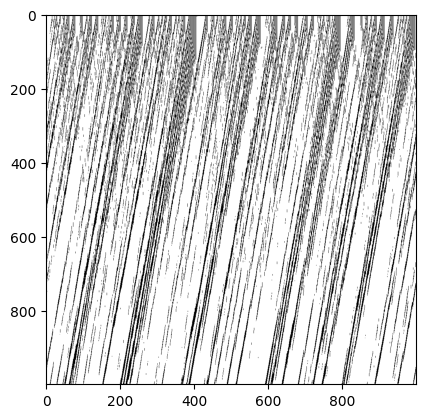

In [7]:
def plot_power_law_fit(plot_data):
    """
    Generates a log-log plot of the avalanche size distribution and its power-law fit.

    Args:
        plot_data (dict): The dictionary of results from compute_criticality_metric_numpy.
    """
    if plot_data is None or not plot_data.get('fit_successful'):
        print("Fit was not successful or no data provided. Cannot generate plot.")
        return

    alpha = plot_data['alpha']
    xmin = plot_data['xmin']
    ks_dist = plot_data['ks_distance']

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the empirical data (avalanche size distribution)
    ax.scatter(plot_data['empirical_pdf_x'], plot_data['empirical_pdf_y'],
               color='blue', alpha=0.7, label='Empirical Data (PDF)')

    # Plot the fitted power-law line
    ax.plot(plot_data['fit_pdf_x'], plot_data['fit_pdf_y'],
            color='red', linestyle='--', linewidth=2,
            label=f'Power-Law Fit (α={alpha:.2f})')

    # Add a vertical line to indicate xmin
    ax.axvline(xmin, color='gray', linestyle=':', linewidth=2,
               label=f'xmin = {xmin}')

    # --- Formatting the plot ---
    ax.set_xlabel('Avalanche Size (s)')
    ax.set_ylabel('Probability P(s)')
    ax.set_title(f'Power-Law Distribution of Avalanche Sizes (KS={ks_dist:.3f})')

    # Set log-log scale, which is essential for visualizing power laws
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
def plot_paper_criticiality_fits(plot_data_list):
    """
    Generates a 2x3 grid of log-log plots to replicate Figure 4 from the paper,
    using the data returned by compute_criticality_from_paper.

    Args:
        plot_data_list (list): A list of 6 dictionaries, one for each distribution.
    """
    if plot_data_list is None or len(plot_data_list) != 6:
        print("Invalid plot data provided. Cannot generate plots.")
        return

    titles = [
        'Avalanche size of state 0', 'Avalanche duration of state 0', 'Avalanche area of state 0',
        'Avalanche size of state 1', 'Avalanche duration of state 1', 'Avalanche area of state 1'
    ]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for i, ax in enumerate(axes.ravel()):
        data = plot_data_list[i]

        if data['empirical_x'] is None:
            ax.set_title(f"{titles[i]}\n(No data)")
            continue

        # Plot the empirical data (blue line in the paper)
        ax.plot(data['empirical_x'], data['empirical_y'], 'b-', marker='o', markersize=4,
                label='Empirical Data (PDF)')

        # Plot the fitted line (dashed black line in the paper)
        if data['fit_x'] is not None:
            ax.plot(data['fit_x'], data['fit_y'], 'k--', linewidth=2,
                    label=f'Fit (α={data["alpha"]:.2f})')

        # --- Formatting ---
        ax.set_title(titles[i])
        ax.set_xlabel('x')
        ax.set_ylabel('P(x)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

fit_res = final_pop[0].fit_res
plot_paper_criticiality_fits(fit_res)
a =  final_pop[0].A
print(a.min(), a.max())
plt.figure(2)
plt.imshow(a[:1000,:1000 ]  >0  , cmap='gray')
print(final_pop[0].theta)

In [8]:
import json
from typing import Dict
Theta = Dict[str, float]
def save_theta(theta: Theta, path: str):
    with open(path, "w") as f:
        json.dump(theta, f, indent=2)

save_theta(final_pop[0].theta, 'Crit_pretraining/1Channel_CEM/pretrained2.json')